In [1]:
import numpy as np
import dedalus.public as d3
import matplotlib.pyplot as plt
import logging
logger = logging.getLogger(__name__)
%config InlineBackend.figure_format = 'retina'

In [2]:
nx = 512
Lx = 1
dealias = 3/2
dtype = np.float64
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=dtype)
xbasis = d3.ChebyshevT(xcoord, size=nx, bounds=(0, Lx), dealias=dealias)

lift_basis = xbasis.derivative_basis(1)
lift = lambda A, n: d3.Lift(A, lift_basis, n)

In [3]:
Pe = 1e2
P = 1/Pe
amp = 0.1

In [4]:
x = dist.local_grid(xbasis)
x_d = dist.local_grid(xbasis, scale=dealias)


c = dist.Field(name='c', bases=xbasis)
τ1 = dist.Field(name='τ1')
τ2 = dist.Field(name='τ2')

u = dist.Field(name='u')
D = dist.Field(name='D', bases=xbasis)
D0 = dist.Field(name='D0', bases=xbasis)

u['g'] = 1
D['g'] = 1 + amp*np.sin(x/Lx*2*np.pi)
D0['g'] = 0.9 #D['g'] #1+amp*2

In [5]:
# Substitutions
dx = lambda A: d3.Differentiate(A, xcoord)

# Problem
problem = d3.IVP([c, τ1, τ2], namespace=locals())
problem.add_equation("dt(c)  - P*D0*dx(dx(c)) + lift(τ1, -1) + lift(τ2, -2) = - u*dx(c) + P*(D-D0)*dx(dx(c))")
problem.add_equation("c(x=0) - c(x=Lx) = 0")
problem.add_equation("dx(c)(x=0) - dx(c)(x=Lx) = 0")

In [6]:
timestepper = d3.SBDF2
Δx = Lx/nx
Δt_cfl = Δx
safety = 0.5
Δt = safety*Δt_cfl
solver = problem.build_solver(timestepper)
solver.stop_sim_time = 1

2022-07-23 22:11:42,612 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.8e+00/s


2022-07-23 22:11:43,009 __main__ 0/1 INFO :: iter = 103, Δt = 0.00098, t = 0.1, c_max = 0.89
2022-07-23 22:11:43,066 __main__ 0/1 INFO :: iter = 205, Δt = 0.00098, t = 0.2, c_max = 0.81
2022-07-23 22:11:43,124 __main__ 0/1 INFO :: iter = 308, Δt = 0.00098, t = 0.3, c_max = 0.75
2022-07-23 22:11:43,181 __main__ 0/1 INFO :: iter = 410, Δt = 0.00098, t = 0.4, c_max = 0.7
2022-07-23 22:11:43,239 __main__ 0/1 INFO :: iter = 513, Δt = 0.00098, t = 0.5, c_max = 0.65
2022-07-23 22:11:43,296 __main__ 0/1 INFO :: iter = 615, Δt = 0.00098, t = 0.6, c_max = 0.62
2022-07-23 22:11:43,353 __main__ 0/1 INFO :: iter = 717, Δt = 0.00098, t = 0.7, c_max = 0.58
2022-07-23 22:11:43,411 __main__ 0/1 INFO :: iter = 820, Δt = 0.00098, t = 0.8, c_max = 0.55
2022-07-23 22:11:43,468 __main__ 0/1 INFO :: iter = 922, Δt = 0.00098, t = 0.9, c_max = 0.53
2022-07-23 22:11:43,525 solvers 0/1 INFO :: Simulation stop time reached.


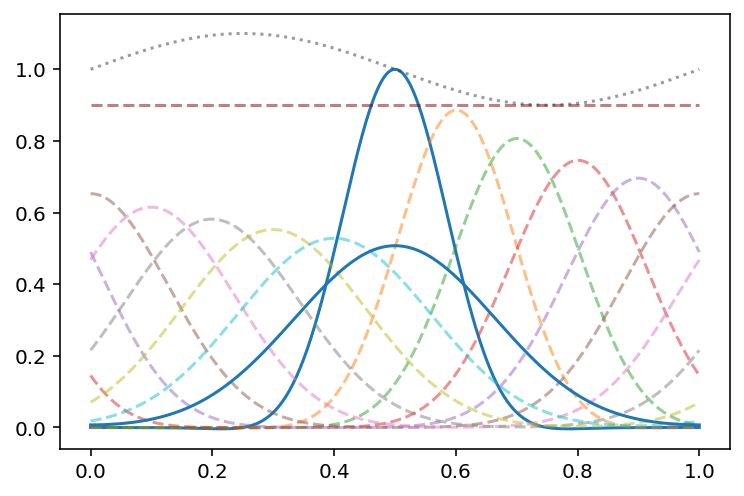

In [7]:
σ = 0.1
x0 = 0.5
c.change_scales(1)
c['g'] = np.cos((x-x0)/Lx*np.pi*2)*np.exp(-(x-x0)**2/(2*σ**2))

fig, ax = plt.subplots()
ax.plot(x, c['g'])
while solver.proceed:
    solver.step(Δt)
    if solver.sim_time % 0.1 < (0 + Δt):
        logger.info("iter = {:d}, Δt = {:.2g}, t = {:.2g}, c_max = {:.2g}".format(solver.iteration, Δt, solver.sim_time, np.max(c['g'])))
        ax.plot(x_d, c['g'], linestyle='dashed', alpha=0.5)
ax.plot(x_d, c['g'])
ax.plot(x_d, D['g'], color='xkcd:dark grey', linestyle='dotted', alpha=0.5)
ax.plot(x_d, D0['g'], color='xkcd:dark red', linestyle='dashed', alpha=0.5)

In [10]:
timestepper = d3.RK222
Δx = Lx/nx
Δt_cfl = Δx
safety = 0.5
Δt = safety*Δt_cfl

c_max = []
c_profiles = []
Ds = []

for system in ['subsystems', 'solvers']:
    logging.getLogger(system).setLevel(logging.WARNING)

for D0_amp in np.geomspace(0.6,5, num=20):
    logger.info("D0 = {:g}".format(D0_amp))
    D0['g'] = D0_amp
    solver = problem.build_solver(timestepper)
    solver.stop_sim_time = 1

    c.change_scales(1)
    c['g'] = np.cos((x-x0)/Lx*np.pi*2)*np.exp(-(x-x0)**2/(2*σ**2))

    while solver.proceed:
        solver.step(Δt)
    c_max.append(np.max(c['g']))
    Ds.append(np.mean(D0['g']))
    c_profiles.append(c['g'])

for D0_amp in [D['g']]:
    D0['g'] = D0_amp
    solver = problem.build_solver(timestepper)
    solver.stop_sim_time = 1

    c.change_scales(1)
    c['g'] = np.cos((x-x0)/Lx*np.pi*2)*np.exp(-(x-x0)**2/(2*σ**2))

    while solver.proceed:
        solver.step(Δt)
    c_truth = np.max(c['g'])
    D_truth = np.mean(D0['g'])

2022-07-23 22:13:25,111 __main__ 0/1 INFO :: D0 = 0.6
2022-07-23 22:13:26,242 __main__ 0/1 INFO :: D0 = 0.670835
2022-07-23 22:13:27,343 __main__ 0/1 INFO :: D0 = 0.750032
2022-07-23 22:13:28,442 __main__ 0/1 INFO :: D0 = 0.838578
2022-07-23 22:13:29,544 __main__ 0/1 INFO :: D0 = 0.937579
2022-07-23 22:13:30,646 __main__ 0/1 INFO :: D0 = 1.04827
2022-07-23 22:13:31,744 __main__ 0/1 INFO :: D0 = 1.17202
2022-07-23 22:13:32,844 __main__ 0/1 INFO :: D0 = 1.31039
2022-07-23 22:13:33,947 __main__ 0/1 INFO :: D0 = 1.46509
2022-07-23 22:13:35,052 __main__ 0/1 INFO :: D0 = 1.63806
2022-07-23 22:13:36,154 __main__ 0/1 INFO :: D0 = 1.83144
2022-07-23 22:13:37,251 __main__ 0/1 INFO :: D0 = 2.04766
2022-07-23 22:13:38,350 __main__ 0/1 INFO :: D0 = 2.2894
2022-07-23 22:13:39,468 __main__ 0/1 INFO :: D0 = 2.55968
2022-07-23 22:13:40,576 __main__ 0/1 INFO :: D0 = 2.86187
2022-07-23 22:13:41,675 __main__ 0/1 INFO :: D0 = 3.19973
2022-07-23 22:13:42,774 __main__ 0/1 INFO :: D0 = 3.57748
2022-07-23 22:1

Text(0, 0.5, '$|c-c_t|$')

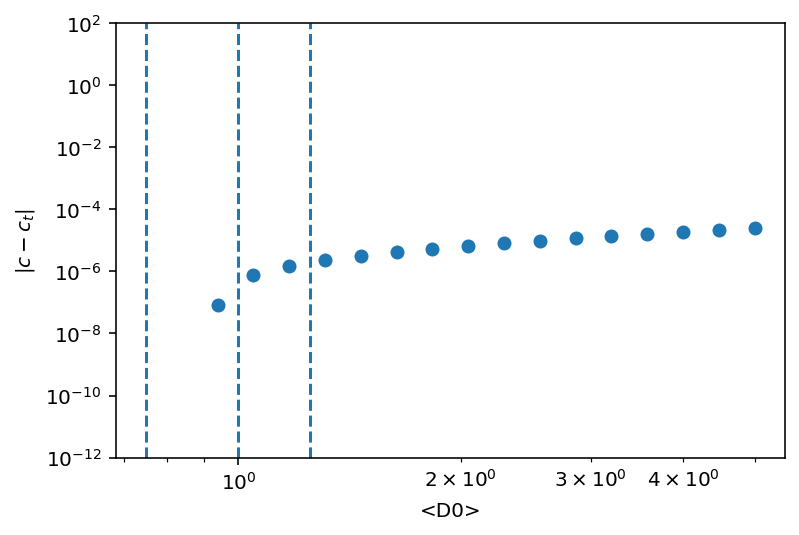

In [11]:
fig, ax = plt.subplots()
ax.scatter(Ds, np.abs(c_max-c_truth))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-12, 1e2)
ax.axvline(x=D_truth, linestyle='dashed')
ax.axvline(x=1.25*D_truth, linestyle='dashed')
ax.axvline(x=0.75*D_truth, linestyle='dashed')

ax.set_xlabel('<D0>')
ax.set_ylabel(r'$|c-c_t|$')

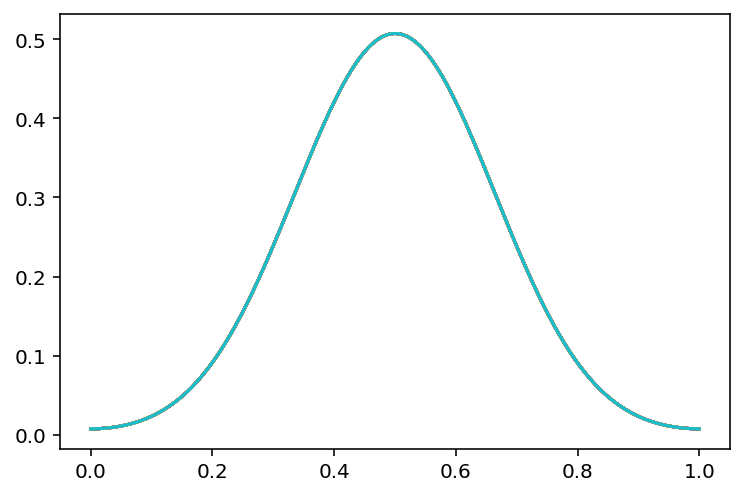

In [12]:
fig, ax = plt.subplots()
for c_i in c_profiles:
    ax.plot(x_d, c_i)

In [13]:
Δx = Lx/nx
Δt_cfl = Δx
safety = 0.5
Δt = safety*Δt_cfl

dataset = {}

for system in ['subsystems', 'solvers']:
    logging.getLogger(system).setLevel(logging.WARNING)

for timestepper in [d3.SBDF1, d3.SBDF2, d3.SBDF3, d3.SBDF4, d3.RK222, d3.RK443]:
    c_max = []
    c_profiles = []
    Ds = []
    logger.info(timestepper)
    for D0_amp in np.geomspace(0.6,5, num=20):
        D0['g'] = D0_amp
        solver = problem.build_solver(timestepper)
        solver.stop_sim_time = 1

        c.change_scales(1)
        c['g'] = np.cos((x-x0)/Lx*np.pi*2)*np.exp(-(x-x0)**2/(2*σ**2))

        while solver.proceed:
            solver.step(Δt)
        c_max.append(np.max(c['g']))
        Ds.append(np.mean(D0['g']))
        c_profiles.append(c['g'])
   
    for D0_amp in [D['g']]:
        D0['g'] = D0_amp
        solver = problem.build_solver(timestepper)
        solver.stop_sim_time = 1

        c.change_scales(1)
        c['g'] = np.cos((x-x0)/Lx*np.pi*2)*np.exp(-(x-x0)**2/(2*σ**2))

        while solver.proceed:
            solver.step(Δt)
        c_truth = np.max(c['g'])
        D_truth = np.mean(D0['g'])
        
    data = {}
        
    data['c_max'] = c_max
    data['c_profile'] = c_profiles
    data['Ds'] = Ds
    data['c_truth'] = c_truth
    data['D_truth'] = D_truth
    
    dataset[timestepper] = data
 

2022-07-23 22:13:48,774 __main__ 0/1 INFO :: <class 'dedalus.core.timesteppers.SBDF1'>
2022-07-23 22:14:01,022 __main__ 0/1 INFO :: <class 'dedalus.core.timesteppers.SBDF2'>
2022-07-23 22:14:13,291 __main__ 0/1 INFO :: <class 'dedalus.core.timesteppers.SBDF3'>
2022-07-23 22:14:25,639 __main__ 0/1 INFO :: <class 'dedalus.core.timesteppers.SBDF4'>
2022-07-23 22:14:38,234 __main__ 0/1 INFO :: <class 'dedalus.core.timesteppers.RK222'>
2022-07-23 22:15:01,613 __main__ 0/1 INFO :: <class 'dedalus.core.timesteppers.RK443'>


Text(0, 0.5, '$|c-c_t|$')

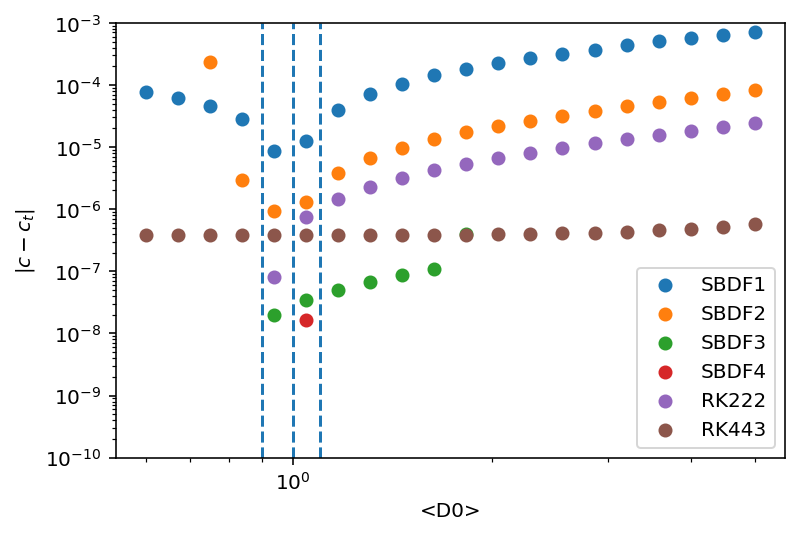

In [14]:
fig, ax = plt.subplots()
for key in dataset:
    c_max = dataset[key]['c_max']
    Ds = dataset[key]['Ds']
    c_truth = dataset[key]['c_truth']
    
    ax.scatter(Ds, np.abs(c_max-c_truth), label=key.__name__)
    
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-10, 1e-3)
ax.axvline(x=D_truth, linestyle='dashed')
ax.axvline(x=D_truth+amp, linestyle='dashed')
ax.axvline(x=D_truth-amp, linestyle='dashed')

ax.set_xlabel('<D0>')
ax.set_ylabel(r'$|c-c_t|$')

In [15]:
truth = d3.RK443

fig, ax = plt.subplots()
for key in dataset:
    c_max = dataset[key]['c_max']
    Ds = dataset[key]['Ds']
    c_truth = dataset[truth]['c_truth']
    
    ax.scatter(Ds, np.abs(c_max-c_truth), label=key.__name__)
    
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim(1e-8, 1e-3)
ax.axvline(x=D_truth, linestyle='dashed')
ax.axvline(x=1.25*D_truth, linestyle='dashed')
ax.axvline(x=0.75*D_truth, linestyle='dashed')

ax.set_xlabel('<D0>')
ax.set_ylabel(r'$|c-c_t|$')

Text(0, 0.5, '$|c-c_t|$')

/Users/bpbrown/miniconda3/envs/dedalus-d3/lib/python3.8/site-packages/matplotlib/ticker.py:2527: RuntimeWarning: overflow encountered in power
  ticklocs = b ** decades
/Users/bpbrown/miniconda3/envs/dedalus-d3/lib/python3.8/site-packages/matplotlib/ticker.py:2357: RuntimeWarning: invalid value encountered in double_scalars
  return abs(x - np.round(x)) < atol
/Users/bpbrown/miniconda3/envs/dedalus-d3/lib/python3.8/site-packages/matplotlib/ticker.py:1174: RuntimeWarning: invalid value encountered in double_scalars
  coeff = round(b ** (fx - exponent))


ValueError: cannot convert float NaN to integer

<Figure size 432x288 with 1 Axes>

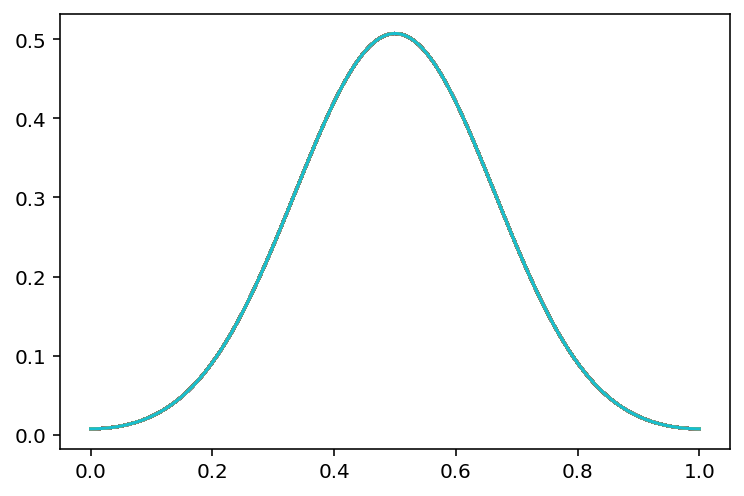

In [16]:
fig, ax = plt.subplots()
for key in dataset:
    c_max = dataset[key]['c_max']
    Ds = dataset[key]['Ds']
    c_truth = dataset[truth]['c_truth']
    for c_i in dataset[key]['c_profile']:
        ax.plot(x_d, c_i)